In [2]:
import pandas as pd

import numpy as np

In [3]:
import importlib

In [22]:
from joblib import Memory

In [4]:
import Parquet_Processor as pqproc

importlib.reload(pqproc)

<module 'Parquet_Processor' from 'd:\\dev\\WIDS2025_MDLV\\Parquet_Processor.py'>

In [5]:

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [8]:
from sklearn.multioutput import MultiOutputClassifier

from lightgbm import LGBMClassifier 

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
import Weighted_F1 as wf1

In [9]:
from sklearn.decomposition import PCA

In [21]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

In [ ]:
import optuna
from optuna import Trial, TrialPruned
from optuna import create_study

d:\dev\WIDS2025_MDLV\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import Feature_Matrix_Generator as matgen
importlib.reload(matgen)

<module 'Feature_Matrix_Generator' from 'd:\\dev\\WIDS2025_MDLV\\Feature_Matrix_Generator.py'>

In [11]:
import matplotlib.pyplot as plt

In [14]:
resources_path = r"D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST"

In [16]:
ds_format_proc = pqproc.Parquet_Processor(folder=resources_path)
parquet_paths = ds_format_proc.convert()

Finished optimizing the data types, achieved memory reduction of 31.109870685645173%
Converted D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TEST_CATEGORICAL.xlsx to D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TEST_CATEGORICAL.parquet
Finished optimizing the data types, achieved memory reduction of 49.97820228003242%
Converted D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv to D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TEST_FUNCTIONAL_CONNECTOME_MATRICES.parquet
Finished optimizing the data types, achieved memory reduction of 33.73404845570557%
Converted D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TEST_QUANTITATIVE_METADATA.xlsx to D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TEST_QUANTITATIVE_METADATA.parquet
Finished optimizing the data types, achieved memory reduction of 16.449528754225714%
Converted D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TRAINING_SOLUTIONS.xlsx to D:\dev\WIDS2025_MDLV\resources\TRAIN_TEST\TRAINING_SOLUTIONS.parquet
Finished optimizing the d

In [17]:

df_train_categ_f = pd.read_parquet(resources_path + r"/TRAIN_CATEGORICAL_METADATA.parquet")
df_train_cant_f = pd.read_parquet(resources_path + r"/TRAIN_QUANTITATIVE_METADATA.parquet")
df_train_funct_f = pd.read_parquet(resources_path + r"/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.parquet")
df_train_o = pd.read_parquet(resources_path + r"/TRAINING_SOLUTIONS.parquet")

df_test_categ_f = pd.read_parquet(resources_path + r"/TEST_CATEGORICAL.parquet")
df_test_cant_f = pd.read_parquet(resources_path + r"/TEST_QUANTITATIVE_METADATA.parquet")
df_test_funct_f = pd.read_parquet(resources_path + r"/TEST_FUNCTIONAL_CONNECTOME_MATRICES.parquet")

In [ ]:
location = "cachedir"
memory = Memory(location=location, verbose=-1)

def instantiate_numerical_preproc_pipeline(trial: Trial) ->Pipeline:
    
    pipeline = Pipeline( steps=[()], memory=memory)

    return pipeline

def instantiate_categorical_preproc_pipeline(trial: Trial) ->Pipeline:
    
    pipeline = Pipeline( steps=[()], memory=memory)

    return pipeline

def instantiate_connectome_preproc_pipeline(trial: Trial) ->Pipeline:
    
    pipeline = Pipeline( steps=[()], memory=memory)

    return pipeline

def instantiate_processor(trial: Trial, numerical_columns : list[str], categorical_columns : list[str], drop_cols : list[str]):

    numerical_preproc_pipeline = instantiate_numerical_preproc_pipeline(trial=trial)
    categorical_preproc_pipeline = instantiate_categorical_preproc_pipeline(trial=trial)
    connectome_preproc_pipeline = instantiate_connectome_preproc_pipeline(trial=trial)

    processor = ColumnTransformer([
        ('dropper', 'drop', drop_cols),
        ('categorical_pipeline', categorical_preproc_pipeline, categorical_columns),
        ('numerical_pipeline', numerical_preproc_pipeline, numerical_columns),
        ('conn_pipeline', connectome_preproc_pipeline, make_column_selector(pattern='column'))
    ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

    return processor



In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, numerical_columns=None, categorical_columns=None, drop_cols=None):
            
            preproc_pipeline = instantiate_processor(trial, numerical_columns=numerical_columns,
                                                      categorical_columns=categorical_columns, 
                                                      drop_cols=drop_cols)

            X_train = preproc_pipeline.fit_transform(X_train, y_train)
            X_val = preproc_pipeline.transform(X_val)

            model = None
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)

            return wf1.weighted_f1(y_true=y_val, y_pred=y_pred)

def objective_cv(trial: Trial, X, y, 
                 inner_cv_splitter=StratifiedKFold(n_splits=5, shuffle=False, random_state=42), 
                 numerical_columns=None, categorical_columns=None, drop_cols=None):       
    
    
    f1_scores = []

    for fold, (train_idx, test_idx) in enumerate(inner_cv_splitter.split(X, y)):

        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

       
        f1_scores.append(objective(trial, X_train, y_train, numerical_columns=numerical_columns, 
                                   categorical_columns=categorical_columns, 
                                   drop_cols=drop_cols))

    return np.mean(f1_scores)

outter_cv_splitter = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)

for fold, (train_idx, test_idx) in enumerate(outter_cv_splitter.split(X, y)):

    outter_X_train, outter_X_test = X.iloc[train_idx], X.iloc[test_idx]
    outter_y_train, outter_y_test = y.iloc[train_idx], y.iloc[test_idx]

    study = create_study(study_name="hyperparrameter_optimization", direction='maximize')

    study.optimize(lambda trial: objective_cv(trial, X=X_train, y=y_train), n_trials=1, n_jobs=1)

    best_params = study.best_params
        





In [18]:
f_connectome_train, f_connectome_test, o_connectome_train, o_connectome_test = train_test_split(df_train_funct_f, df_train_o, test_size=0.1, random_state=42)

In [19]:
connectome_f_proc= matgen.Feature_Matrix_Generator()


In [20]:

f_connectome_train = f_connectome_train.drop(columns = ["participant_id"])


In [20]:

train_connectome_matrices = connectome_f_proc.gen_connectome_matrix(f_connectome_train)


In [154]:
f_connectome_test = f_connectome_test.drop(columns = ["participant_id"])


In [155]:


test_connectome_matrices = connectome_f_proc.gen_connectome_matrix(f_connectome_test)

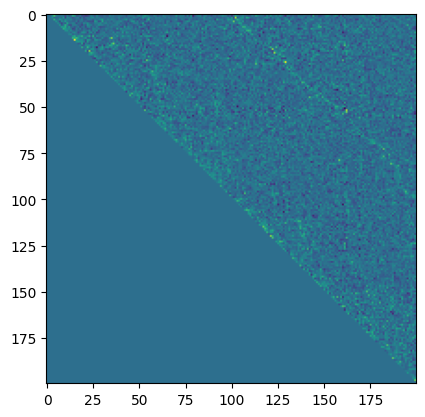

In [23]:
plt.imshow(train_connectome_matrices[5])

In [18]:
o_adhd_train = o_connectome_train.loc[:, "ADHD_Outcome"].copy()

o_adhd_test = o_connectome_test.loc[:, "ADHD_Outcome"].copy()

In [36]:

cnn_model = build_full_cnn(input_shape=train_connectome_matrices.shape, num_classes=1)  # ADHD/Sex classification

cnn_model.fit(train_connectome_matrices, o_adhd_train, epochs=20, batch_size=1, validation_data=(test_connectome_matrices, o_adhd_test))

d:\dev\WIDS2025_MDLV\wids_venv_3-11-4\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Kernel shape must have the same length as input, but received kernel of shape (3, 3, 1, 32) and input of shape (None, 1091, 199, 199, 1).

In [4]:


def impute_missing_values(df: pd.DataFrame, 
                          categorical_columns=None, continuous_columns=None,
                          threshold=0.1, advanced_imputer="knn"):
    missing_percent = df.isnull().mean()  # Get % of missing values per column
    
    # Separate columns based on threshold
    low_missing = missing_percent[missing_percent < threshold].index
    high_missing = missing_percent[missing_percent >= threshold].index

    # Ensure categorical_columns and continuous_columns are lists
    categorical_columns = categorical_columns or []
    continuous_columns = continuous_columns or []
    
    # Simple imputation based on provided column lists
    for col in low_missing:
        if col in df.columns:  # Check if column exists
            if col in categorical_columns:  # Categorical
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif col in continuous_columns:  # Numeric
                df[col].fillna(df[col].mean(), inplace=True)

    # ML-based imputation for high missing columns
    if len(high_missing) > 0:
        if advanced_imputer == "knn":
            imputer = KNNImputer(n_neighbors=5)
        elif advanced_imputer == "iterative":
            imputer = IterativeImputer()
        else:
            raise ValueError("Invalid ML imputer. Choose 'knn' or 'iterative'.")
        
        df[high_missing] = imputer.fit_transform(df[high_missing])
    
    return df


NameError: name 'pd' is not defined

In [32]:

categ_cols = [col for col in df_test_categ_f.columns.to_list() if col != 'participant_id']
impute_missing_values(df_train_categ_f, threshold=0.1, categorical_columns=categ_cols)


cant_cols = [col for col in df_train_cant_f.columns.to_list() if col != 'participant_id']
impute_missing_values(df_train_cant_f, threshold=0.1, continuous_columns=cant_cols)

C:\Users\lucab\AppData\Local\Temp\ipykernel_13892\1422354528.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\lucab\AppData\Local\Temp\ipykernel_13892\1422354528.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.000000,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,11.245679
1,CPaeQkhcjg7d,-94.470001,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,11.245679
2,Nb4EetVPm3gs,-46.669998,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.680000,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,11.245679
4,M09PXs7arQ5E,0.000000,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.800003,14,5,14,39,20,15,21,1,9,2,7,3,6,2,0,9,10.697923
1209,groSbUfkQngM,77.800003,14,3,10,32,20,11,23,6,18,3,11,9,5,7,4,7,13.964750
1210,zmxGvIrOD0bt,16.680000,14,3,16,28,15,19,27,3,4,1,3,0,0,1,0,10,11.245679
1211,rOmWFuJCud5G,53.400002,14,3,14,34,18,23,23,4,9,0,9,3,5,0,0,9,12.089094


In [15]:

patient_ids = df_train_funct_f['participant_id']  # Assuming it's a column, not the index

# Step 2: Drop the 'patient_id' column and apply PCA
df_selected_f = df_train_funct_f.drop(columns=['participant_id'])  # Remove non-numeric data
pca_processor = PCA(n_components=0.95)  # Keep 95% variance
df_train_funct_f_reduced = pca_processor.fit_transform(df_selected_f)

# Step 3: Convert the PCA result back into a DataFrame
df_train_funct_f_reduced = pd.DataFrame(df_train_funct_f_reduced, columns=[f"PCA_{i}" for i in range(df_train_funct_f_reduced.shape[1])])

# Step 4: Reattach 'patient_id' column
df_train_funct_f_reduced['participant_id'] = patient_ids.values  # Ensure IDs are added back in the correct order

# Step 5: (Optional) Reorder columns to keep 'patient_id' first
cols = ['participant_id'] + [col for col in df_train_funct_f_reduced.columns if col != 'participant_id']
df_train_funct_f_reduced = df_train_funct_f_reduced[cols]

df_train_funct_f_reduced= ds_format_proc.optimize_dataframe(df_train_funct_f_reduced)

Finished optimizing the data types, achieved memory reduction of 0.0%


In [16]:
df_train_f = pd.merge((pd.merge(df_train_categ_f,df_train_cant_f,on="participant_id")),df_train_funct_f_reduced,on="participant_id")
df_test_f = pd.merge((pd.merge(df_test_categ_f,df_test_cant_f,on="participant_id")),df_train_funct_f_reduced,on="participant_id")

In [12]:
df_train_f = pd.merge(df_train_categ_f,df_train_cant_f,on="participant_id")
df_test_f = pd.merge(df_test_categ_f,df_test_cant_f,on="participant_id")

In [30]:
df_train_f = pd.merge((pd.merge(df_train_categ_f,df_train_cant_f,on="participant_id")),df_train_funct_f,on="participant_id")
df_test_f = pd.merge((pd.merge(df_test_categ_f,df_test_cant_f,on="participant_id")),df_train_funct_f,on="participant_id")

In [17]:
targets = ['ADHD_Outcome','Sex_F']

df_adhd_o =  df_train_o['ADHD_Outcome'].copy()
df_sex_o =df_train_o['Sex_F'].copy()


In [18]:
df_merged_o = df_adhd_o*2 + df_sex_o

display(df_merged_o)

0       3
1       2
2       2
3       3
4       3
       ..
1208    0
1209    1
1210    1
1211    0
1212    0
Length: 1213, dtype: int8

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
lgbmc_model = LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(df_merged_o)),  # Change this based on your dataset
    metric="multi_logloss",  # Can also try "multi_error"
    boosting_type="gbdt",
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31
)

In [20]:

#model = MultiOutputClassifier(LGBMClassifier())

xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    objective="multi:softmax",
    num_class=len(np.unique(df_merged_o)),  
    tree_method="hist"
)

xgb_model.set_params(eval_metric="mlogloss")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [21]:
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    objective="binary:logistic",  # Since both ADHD and Sex_F are binary
    tree_method="hist"
)

multi_xgb = MultiOutputClassifier(xgb_model)

In [19]:

xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1)  # No tuning yet

In [22]:
df_train_f.drop(columns=['participant_id'], axis=1, inplace=True)


In [45]:
display(df_merged_o)

0       3
1       2
2       2
3       3
4       3
       ..
1208    0
1209    1
1210    1
1211    0
1212    0
Length: 1213, dtype: int8

In [45]:
fold_f1_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(df_train_f, df_merged_o)):
    f_train, f_test = df_train_f.iloc[train_idx], df_train_f.iloc[test_idx]
    o_train, o_test = df_merged_o.iloc[train_idx], df_merged_o.iloc[test_idx]

    # Train XGBoost
    xgb_model.fit(f_train, o_train)

    # Predict
    o_pred = xgb_model.predict(f_test)

    # Evaluate
    f1 = f1_score(o_test, o_pred, average='micro')
    fold_f1_scores.append(f1)

In [37]:
fold_f1_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(df_train_f, df_merged_o)):
    f_train, f_test = df_train_f.iloc[train_idx], df_train_f.iloc[test_idx]
    o_train, o_test = df_merged_o.iloc[train_idx], df_merged_o.iloc[test_idx]

    # Train
    lgbmc_model.fit(f_train, o_train)

    # Predict
    o_pred = lgbmc_model.predict(f_test)

    # Evaluate
    f1 = f1_score(o_test, o_pred, average='micro')
    fold_f1_scores.append(f1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1,380748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5075170
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 19927
[LightGBM] [Info] Start training from score -1,724004
[LightGBM] [Info] Start training from score -1,986947
[LightGBM] [Info] Start training from score -0,737412
[LightGBM] [Info] Start training from score -1,578979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [38]:

# Initialize MultiOutputClassifier with LightGBM
multi_output_model = MultiOutputClassifier(xgb_model)

fold_f1_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(df_train_f, df_merged_o)):
    f_train, f_test = df_train_f.iloc[train_idx], df_train_f.iloc[test_idx]
    o_train, o_test = df_merged_o.iloc[train_idx], df_merged_o.iloc[test_idx]


    smote_processor = SMOTE(sampling_strategy="auto", random_state=42)

    f_train_resampled, o_train_resampled = smote_processor.fit_resample(f_train,o_train)

    f_test_resampled, o_test_resampled = smote_processor.fit_resample(f_test,o_test)
    
    # Reconstruct target columns
    adhd_train = (o_train_resampled >= 2).astype(int)  # ADHD_Outcome = 1 if 2 or 3
    sex_train = (o_train_resampled % 2).astype(int)    # Sex_F = 1 if odd

    adhd_test = (o_test_resampled >= 2).astype(int)
    sex_test = (o_test_resampled % 2).astype(int)

    df_test_merged = pd.DataFrame({
    'ADHD_Outcome': adhd_test,
    'Sex_F': sex_test
    })

    # Train MultiOutputClassifier
    multi_output_model.fit(f_train_resampled, np.column_stack((adhd_train, sex_train)))

    # Predict
    o_pred = multi_output_model.predict(f_test_resa)
    #adhd_pred, sex_pred = o_pred[:, 0], o_pred[:, 1]

    weighted_f1 = wf1.weighted_f1(df_test_merged, o_pred)

    # Evaluate separately
    #f1_adhd = f1_score(adhd_test, adhd_pred, average='micro')
    #f1_sex = f1_score(sex_test, sex_pred, average='micro')

    fold_f1_scores.append(weighted_f1)

In [40]:
# Initialize MultiOutputClassifier with LightGBM
multi_output_model = MultiOutputClassifier(xgb_model)

fold_f1_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(df_train_f, df_merged_o)):
    f_train, f_test = df_train_f.iloc[train_idx], df_train_f.iloc[test_idx]
    o_train, o_test = df_merged_o.iloc[train_idx], df_merged_o.iloc[test_idx]


    smote_processor = SMOTE(sampling_strategy="auto", random_state=42)

    f_train_resampled, o_train_resampled = smote_processor.fit_resample(f_train,o_train)

    #f_test_resampled, o_test_resampled = smote_processor.fit_resample(f_test,o_test)
    
    # Reconstruct target columns
    adhd_train = (o_train_resampled >= 2).astype(int)  # ADHD_Outcome = 1 if 2 or 3
    sex_train = (o_train_resampled % 2).astype(int)    # Sex_F = 1 if odd

    adhd_test = (o_test >= 2).astype(int)
    sex_test = (o_test % 2).astype(int)

    df_test_merged = pd.DataFrame({
    'ADHD_Outcome': adhd_test,
    'Sex_F': sex_test
    })

    # Train MultiOutputClassifier
    multi_output_model.fit(f_train_resampled, np.column_stack((adhd_train, sex_train)))

    # Predict
    o_pred = multi_output_model.predict(f_test)
    #adhd_pred, sex_pred = o_pred[:, 0], o_pred[:, 1]

    weighted_f1 = wf1.weighted_f1(df_test_merged, o_pred)

    # Evaluate separately
    #f1_adhd = f1_score(adhd_test, adhd_pred, average='micro')
    #f1_sex = f1_score(sex_test, sex_pred, average='micro')

    fold_f1_scores.append(weighted_f1)

In [41]:
print(fold_f1_scores)

[0.4612885349902727, 0.41809771520064853, 0.44345708180133253, 0.49290388463664114, 0.49993408719072263]
